In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
import os

In [3]:
# ============================================================
# Load raw data
# ============================================================
df_weekly_cn = pd.read_csv("Project/Data/China/Weekly Market Information of Domestic Index165542650/IDX_Idxtrdweek.csv")
df_index_cn  = pd.read_csv("Project/Data/China/Index Profile170027150/IDX_Idxinfo.csv")

# Ensure index code is the same type in both tables
df_weekly_cn["Indexcd"] = df_weekly_cn["Indexcd"].astype(str)
df_index_cn["Indexcd"]  = df_index_cn["Indexcd"].astype(str)

/var/folders/wp/k5t4pl853ng8y6kktqkmy3n80000gn/T/ipykernel_33787/4064318882.py:4: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_weekly_cn = pd.read_csv("Project/Data/China/Weekly Market Information of Domestic Index165542650/IDX_Idxtrdweek.csv")


In [4]:
# ============================================================
# Read and merge all yearly US index files (2005–2025)
# ============================================================
csv_files = [
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2005.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2006.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2007.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2008.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2009.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2010.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2011.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2012.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2013.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2014.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2015.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2016.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2017.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2018.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2019.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2020.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2021.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2022.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2023.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2024.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2025.csv",
]

all_dfs_us = []
for fp in csv_files:
    df = pd.read_csv(fp)
    df["source_file"] = os.path.basename(fp)
    all_dfs_us.append(df)

merged_full_df_us = pd.concat(all_dfs_us, ignore_index=True)
out_merged_us = "Project/Data/USA/Combined/TRDA_Gidxtrd_2005_2025_merged.csv"
merged_full_df_us.to_csv(out_merged_us, index=False)
print(f"✅ Merged {len(csv_files)} files → {out_merged_us}")
print(f"   Total rows: {len(merged_full_df_us):,}")


✅ Merged 21 files → Project/Data/USA/Combined/TRDA_Gidxtrd_2005_2025_merged.csv
   Total rows: 7,157,595


In [5]:
# ============================================================
# Merge weekly quotes with index names
# ============================================================
merged_weekly_cn = pd.merge(
    df_weekly_cn,
    df_index_cn[["Indexcd", "Idxinfo01_en"]],   # only the columns we need
    on="Indexcd",
    how="left"
)

# Keep only relevant columns and rename for clarity
merged_weekly_cn = merged_weekly_cn[["Idxinfo01_en", "Indexcd", "Week", "Clsidx"]]
merged_weekly_cn.columns = ["EnglishName", "IndexCode", "Date", "Closing"]

display(merged_weekly_cn.head(10))

,EnglishName,IndexCode,Date,Closing
0,SSE Composite Index,000001,1991-01,131.44
1,SSE Composite Index,000001,1991-02,134.60
2,SSE Composite Index,000001,1991-03,134.24
3,SSE Composite Index,000001,1991-04,132.05
4,SSE Composite Index,000001,1991-05,129.51
5,SSE Composite Index,000001,1991-06,130.38
6,SSE Composite Index,000001,1991-07,132.53
7,SSE Composite Index,000001,1991-08,134.87
8,SSE Composite Index,000001,1991-09,132.53
9,SSE Composite Index,000001,1991-10,129.89


In [6]:
# ============================================================
# Keep only Fridays and normalize columns
# ============================================================
def keep_fridays(df: pd.DataFrame):
    """Detect date column, parse, and keep only Fridays."""
    date_col = None
    for cand in ["Trddt", "Date", "date", "DATE"]:
        if cand in df.columns:
            date_col = cand
            break
    if date_col is None:
        raise ValueError("No date column found (expected one of: Trddt, Date, date, DATE).")

    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df = df.dropna(subset=[date_col])
    df = df[df[date_col].dt.weekday == 4].copy()  # 4 = Friday
    return df, date_col

friday_parts = []
rows_before, rows_after = 0, 0

for fp in csv_files:
    tmp = pd.read_csv(fp)
    rows_before += len(tmp)
    tmp, dt_col = keep_fridays(tmp)
    tmp["source_file"] = os.path.basename(fp)
    rows_after += len(tmp)
    friday_parts.append(tmp)
    print(f"✔ {os.path.basename(fp)}: {len(tmp):,} Friday rows")

friday_df = pd.concat(friday_parts, ignore_index=True)

# keep useful columns if they exist
keep_cols = [c for c in ["Indexcd", "IndexName", "Clsidx", dt_col, "source_file"] if c in friday_df.columns]
friday_df = friday_df[keep_cols]

out_fridays = "Project/Data/USA/Combined/TRDA_Gidxtrd_2005_2025_FRIDAYS_merged.csv"
friday_df.to_csv(out_fridays, index=False)

print("\n✅ Friday-only merge complete.")
print(f"   Rows before filter: {rows_before:,}")
print(f"   Rows after filter:  {rows_after:,}")
print(f"   Output: {out_fridays}")


✔ TRDA_Gidxtrd_2005.csv: 39,874 Friday rows
✔ TRDA_Gidxtrd_2006.csv: 77,199 Friday rows
✔ TRDA_Gidxtrd_2007.csv: 74,692 Friday rows
✔ TRDA_Gidxtrd_2008.csv: 109,679 Friday rows
✔ TRDA_Gidxtrd_2009.csv: 121,857 Friday rows
✔ TRDA_Gidxtrd_2010.csv: 116,933 Friday rows
✔ TRDA_Gidxtrd_2011.csv: 120,666 Friday rows
✔ TRDA_Gidxtrd_2012.csv: 122,046 Friday rows
✔ TRDA_Gidxtrd_2013.csv: 122,470 Friday rows
✔ TRDA_Gidxtrd_2014.csv: 113,143 Friday rows
✔ TRDA_Gidxtrd_2015.csv: 112,220 Friday rows
✔ TRDA_Gidxtrd_2016.csv: 115,264 Friday rows
✔ TRDA_Gidxtrd_2017.csv: 104,535 Friday rows
✔ TRDA_Gidxtrd_2018.csv: 40,131 Friday rows
✔ TRDA_Gidxtrd_2019.csv: 1,887 Friday rows
✔ TRDA_Gidxtrd_2020.csv: 1,814 Friday rows
✔ TRDA_Gidxtrd_2021.csv: 1,887 Friday rows
✔ TRDA_Gidxtrd_2022.csv: 1,888 Friday rows
✔ TRDA_Gidxtrd_2023.csv: 1,885 Friday rows
✔ TRDA_Gidxtrd_2024.csv: 1,815 Friday rows
✔ TRDA_Gidxtrd_2025.csv: 1,517 Friday rows

✅ Friday-only merge complete.
   Rows before filter: 7,157,595
   Rows a

In [7]:
us_cn_mapping = {
    "NASDAQ Health Care": [
        "CSI 800 Pharmaceuticals and Biotechnology Index",
        "CSI Health Care 100 Index",
        "Pharmaceutical & Biological Index",
        "SSE STAR Biology and Medicine Index"
    ],
    "NQ Biotechnology": [
        "SSE STAR Biology and Medicine Index",
        "CSI WIND Biotechnology Index"
    ],
    "NQ Computer": [
        "SSE Information Technology Sector index",
        "CSI Information Technology index",
        "SZSE Information Technology Sector Index",
        "ELECTRONIC EQUIPMENT INDEX",
        "Information equipment"
    ],
    "NQ Internet": [
        "SSE Information Technology Sector index",
        "CSI Information Technology index",
        "SZSE Information Technology Sector Index",
        "ELECTRONIC EQUIPMENT INDEX",
        "Information equipment"
    ],
    "NQ Industrial": [
        "SSE Upstream Industry Index",
        "SSE Midstream Industry Index",
        "SSE Downstream Industry Index",
        "CSI Midstream Manufacturing Industry Index"
    ],
    "NQ Transportation": [
        "Transportation & Storage Index",
        "CSI China Mainland Transportation index"
    ]
}


In [8]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests

# ------------------------------------------------------------
# 1) US weekly (friday_df): make YearWeek from actual dates
# ------------------------------------------------------------
for cand in ["Date", "Trddt", "date", "DATE"]:
    if cand in friday_df.columns:
        us_date_col = cand
        break
else:
    raise ValueError("No date column found in friday_df")

friday_df[us_date_col] = pd.to_datetime(friday_df[us_date_col], errors="coerce")
iso = friday_df[us_date_col].dt.isocalendar()
friday_df["YearWeek"] = iso.year.astype(str) + "-" + iso.week.astype(str).str.zfill(2)

# ------------------------------------------------------------
# 2) CN weekly (merged_weekly_us): already "YYYY-WW"
# ------------------------------------------------------------
merged_weekly_cn["YearWeek"] = merged_weekly_cn["Date"].astype(str)

# ------------------------------------------------------------
# 3) mapping US -> list of CN indices you want to test against
# ------------------------------------------------------------


# ------------------------------------------------------------
# helper: compute weekly log returns
# ------------------------------------------------------------
def compute_log_returns(df, price_col, out_col):
    df = df.sort_values("YearWeek").copy()
    df[price_col] = pd.to_numeric(df[price_col], errors="coerce")
    df[out_col] = np.log(df[price_col]).diff()
    return df[["YearWeek", out_col]].dropna()

# ------------------------------------------------------------
# helper: extract best (smallest) p-value from statsmodels result
# ------------------------------------------------------------
def best_granger_p(two_col_array: np.ndarray, maxlag: int) -> float:
    """
    two_col_array[:,0] = dependent
    two_col_array[:,1] = potential cause
    returns min p-value across lags
    """
    res = grangercausalitytests(two_col_array, maxlag=maxlag, verbose=False)
    pvals = []
    for lag, out in res.items():
        # out is usually a tuple: (testdict, extra)
        if isinstance(out, tuple):
            testdict = out[0]
        else:
            testdict = out
        if "ssr_ftest" in testdict:
            pvals.append(testdict["ssr_ftest"][1])
    return min(pvals) if pvals else np.nan

# ------------------------------------------------------------
# 4) run over all pairs
# ------------------------------------------------------------
max_lag = 4
rows = []

for us_name, cn_names in us_cn_mapping.items():
    # US slice
    us_sub = friday_df[friday_df["IndexName"] == us_name].copy()
    if us_sub.empty:
        print(f"⚠️ US index '{us_name}' not found.")
        continue
    us_ret = compute_log_returns(us_sub, "Clsidx", "US_Ret")

    for cn_name in cn_names:
        cn_sub = merged_weekly_cn[merged_weekly_cn["EnglishName"] == cn_name].copy()
        if cn_sub.empty:
            print(f"⚠️ CN index '{cn_name}' not found.")
            continue
        cn_ret = compute_log_returns(cn_sub, "Closing", "CN_Ret")

        # align by YearWeek
        merged = pd.merge(us_ret, cn_ret, on="YearWeek", how="inner").dropna()
        if len(merged) < max_lag + 10:
            print(f"⚠️ {us_name} ↔ {cn_name}: too few common weeks ({len(merged)}).")
            continue

        data = merged[["US_Ret", "CN_Ret"]].to_numpy()

        print(f"\n=== {us_name} ↔ {cn_name} (n={len(merged)}) ===")

        # CN → US
        p_cn_us = best_granger_p(data, max_lag)
        print(f"   best p CN→US: {p_cn_us:.4f}" if not np.isnan(p_cn_us) else "   best p CN→US: nan")

        # US → CN (swap columns)
        p_us_cn = best_granger_p(data[:, ::-1], max_lag)
        print(f"   best p US→CN: {p_us_cn:.4f}" if not np.isnan(p_us_cn) else "   best p US→CN: nan")

        rows.append(
            {
                "US_Index": us_name,
                "CN_Index": cn_name,
                "n_obs": len(merged),
                "p_CN_to_US": p_cn_us,
                "p_US_to_CN": p_us_cn,
            }
        )

# results table
granger_results = pd.DataFrame(rows).sort_values(["p_US_to_CN", "p_CN_to_US"])
display(granger_results)



=== NASDAQ Health Care ↔ CSI 800 Pharmaceuticals and Biotechnology Index (n=631) ===
   best p CN→US: 0.0574
   best p US→CN: 0.1106

=== NASDAQ Health Care ↔ CSI Health Care 100 Index (n=1106) ===
   best p CN→US: 0.2511
   best p US→CN: 0.1269

=== NASDAQ Health Care ↔ Pharmaceutical & Biological Index (n=368) ===
   best p CN→US: 0.8072
   best p US→CN: 0.0948

=== NASDAQ Health Care ↔ SSE STAR Biology and Medicine Index (n=284) ===
   best p CN→US: 0.5569
   best p US→CN: 0.3614

=== NQ Biotechnology ↔ SSE STAR Biology and Medicine Index (n=284) ===
   best p CN→US: 0.6335
   best p US→CN: 0.5216

=== NQ Biotechnology ↔ CSI WIND Biotechnology Index (n=514) ===
   best p CN→US: 0.1586
   best p US→CN: 0.3856

=== NQ Computer ↔ SSE Information Technology Sector index (n=825) ===
   best p CN→US: 0.1089
   best p US→CN: 0.0009


/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/ts


=== NQ Computer ↔ CSI Information Technology index (n=1606) ===
   best p CN→US: 0.0000
   best p US→CN: 0.0011

=== NQ Computer ↔ SZSE Information Technology Sector Index (n=1018) ===
   best p CN→US: 0.5185
   best p US→CN: 0.0000

=== NQ Computer ↔ ELECTRONIC EQUIPMENT INDEX (n=394) ===
   best p CN→US: 0.4629
   best p US→CN: 0.0000

=== NQ Computer ↔ Information equipment (n=544) ===
   best p CN→US: 0.6409
   best p US→CN: 0.0003

=== NQ Internet ↔ SSE Information Technology Sector index (n=659) ===
   best p CN→US: 0.1538
   best p US→CN: 0.0106

=== NQ Internet ↔ CSI Information Technology index (n=1318) ===
   best p CN→US: 0.0000
   best p US→CN: 0.0054

=== NQ Internet ↔ SZSE Information Technology Sector Index (n=659) ===
   best p CN→US: 0.1791
   best p US→CN: 0.0013


/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/ts


=== NQ Internet ↔ ELECTRONIC EQUIPMENT INDEX (n=35) ===
   best p CN→US: 0.2199
   best p US→CN: 0.0815

=== NQ Internet ↔ Information equipment (n=185) ===
   best p CN→US: 0.2243
   best p US→CN: 0.0195

=== NQ Industrial ↔ SSE Upstream Industry Index (n=711) ===
   best p CN→US: 0.0341
   best p US→CN: 0.0144

=== NQ Industrial ↔ SSE Midstream Industry Index (n=711) ===
   best p CN→US: 0.5474
   best p US→CN: 0.0174

=== NQ Industrial ↔ SSE Downstream Industry Index (n=711) ===
   best p CN→US: 0.3529
   best p US→CN: 0.0112

=== NQ Industrial ↔ CSI Midstream Manufacturing Industry Index (n=1502) ===
   best p CN→US: 0.7753
   best p US→CN: 0.0121

=== NQ Transportation ↔ Transportation & Storage Index (n=368) ===
   best p CN→US: 0.2643
   best p US→CN: 0.0079


/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/ts


=== NQ Transportation ↔ CSI China Mainland Transportation index (n=1545) ===
   best p CN→US: 0.3610
   best p US→CN: 0.1111


/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


,US_Index,CN_Index,n_obs,p_CN_to_US,p_US_to_CN
8,NQ Computer,SZSE Information Technology Sector Index,1018,0.518470,0.000012
9,NQ Computer,ELECTRONIC EQUIPMENT INDEX,394,0.462878,0.000024
10,NQ Computer,Information equipment,544,0.640919,0.000295
6,NQ Computer,SSE Information Technology Sector index,825,0.108899,0.000944
7,NQ Computer,CSI Information Technology index,1606,0.000009,0.001144
13,NQ Internet,SZSE Information Technology Sector Index,659,0.179080,0.001346
12,NQ Internet,CSI Information Technology index,1318,0.000013,0.005375
20,NQ Transportation,Transportation & Storage Index,368,0.264253,0.007858
11,NQ Internet,SSE Information Technology Sector index,659,0.153816,0.010569
18,NQ Industrial,SSE Downstream Industry Index,711,0.352874,0.011177


In [9]:
# Filterbedingungen
filtered = granger_results[
    (granger_results["n_obs"] >= 520) & 
    (
        (granger_results["p_CN_to_US"] <= 0.10) | 
        (granger_results["p_US_to_CN"] <= 0.10)
    )
].copy()

# Nach Signifikanz sortieren (z.B. stärkster US→CN zuerst)
filtered = filtered.sort_values(["p_US_to_CN", "p_CN_to_US"]).reset_index(drop=True)

display(filtered)



,US_Index,CN_Index,n_obs,p_CN_to_US,p_US_to_CN
0,NQ Computer,SZSE Information Technology Sector Index,1018,0.518470,0.000012
1,NQ Computer,Information equipment,544,0.640919,0.000295
2,NQ Computer,SSE Information Technology Sector index,825,0.108899,0.000944
3,NQ Computer,CSI Information Technology index,1606,0.000009,0.001144
4,NQ Internet,SZSE Information Technology Sector Index,659,0.179080,0.001346
5,NQ Internet,CSI Information Technology index,1318,0.000013,0.005375
6,NQ Internet,SSE Information Technology Sector index,659,0.153816,0.010569
7,NQ Industrial,SSE Downstream Industry Index,711,0.352874,0.011177
8,NQ Industrial,CSI Midstream Manufacturing Industry Index,1502,0.775334,0.012105
9,NQ Industrial,SSE Upstream Industry Index,711,0.034079,0.014396


In [10]:
# 1) Ausgangspunkt: deine bestehende Ergebnistabelle
#    (so wie du sie oben gebaut hast)
# granger_results: Spalten = ["US_Index","CN_Index","n_obs","p_CN_to_US","p_US_to_CN"]

min_obs = 520
alpha = 0.10

# 2) US-getriebene Paare (US -> CN signifikant)
us_driven = (
    granger_results[
        (granger_results["n_obs"] >= min_obs) &
        (granger_results["p_US_to_CN"] <= alpha)
    ]
    .sort_values(["p_US_to_CN", "p_CN_to_US"])
    .reset_index(drop=True)
)

# 3) CN-getriebene Paare (CN -> US signifikant)
cn_driven = (
    granger_results[
        (granger_results["n_obs"] >= min_obs) &
        (granger_results["p_CN_to_US"] <= alpha)
    ]
    .sort_values(["p_CN_to_US", "p_US_to_CN"])
    .reset_index(drop=True)
)

display(us_driven)
display(cn_driven)


,US_Index,CN_Index,n_obs,p_CN_to_US,p_US_to_CN
0,NQ Computer,SZSE Information Technology Sector Index,1018,0.518470,0.000012
1,NQ Computer,Information equipment,544,0.640919,0.000295
2,NQ Computer,SSE Information Technology Sector index,825,0.108899,0.000944
3,NQ Computer,CSI Information Technology index,1606,0.000009,0.001144
4,NQ Internet,SZSE Information Technology Sector Index,659,0.179080,0.001346
5,NQ Internet,CSI Information Technology index,1318,0.000013,0.005375
6,NQ Internet,SSE Information Technology Sector index,659,0.153816,0.010569
7,NQ Industrial,SSE Downstream Industry Index,711,0.352874,0.011177
8,NQ Industrial,CSI Midstream Manufacturing Industry Index,1502,0.775334,0.012105
9,NQ Industrial,SSE Upstream Industry Index,711,0.034079,0.014396


,US_Index,CN_Index,n_obs,p_CN_to_US,p_US_to_CN
0,NQ Computer,CSI Information Technology index,1606,0.000009,0.001144
1,NQ Internet,CSI Information Technology index,1318,0.000013,0.005375
2,NQ Industrial,SSE Upstream Industry Index,711,0.034079,0.014396
3,NASDAQ Health Care,CSI 800 Pharmaceuticals and Biotechnology Index,631,0.057432,0.110591


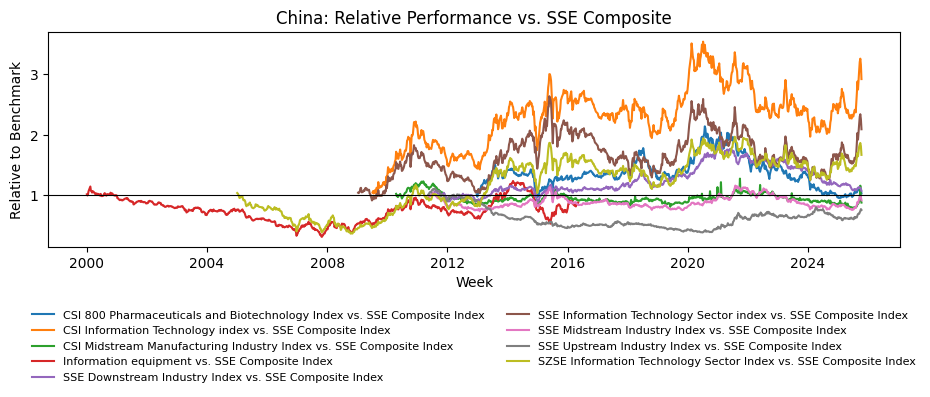

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

min_obs = 520
alpha = 0.10

# 1) Filtered pairs (significant and sufficient observations)
filtered = granger_results[
    (granger_results["n_obs"] >= min_obs) &
    (
        (granger_results["p_CN_to_US"] <= alpha) |
        (granger_results["p_US_to_CN"] <= alpha)
    )
].copy()

cn_indices = sorted(filtered["CN_Index"].unique().tolist())

# 2) Prepare Chinese weekly data
cn_df = merged_weekly_cn.copy()
cn_df["Closing"] = pd.to_numeric(cn_df["Closing"], errors="coerce")
cn_df.loc[cn_df["Closing"] <= 0, "Closing"] = np.nan

def iso_week_to_date(s):
    year, week = s.split("-")
    return pd.Timestamp.fromisocalendar(int(year), int(week), 1)

cn_df["WeekStart"] = cn_df["Date"].astype(str).apply(iso_week_to_date)

# Keep only relevant indices
cn_df = cn_df[cn_df["EnglishName"].isin(cn_indices)].copy()

# Aggregate if multiple entries per week
cn_df = (
    cn_df
    .groupby(["EnglishName", "WeekStart"], as_index=False)["Closing"]
    .mean()
    .sort_values(["EnglishName", "WeekStart"])
)

# Compute weekly log returns
cn_df["LogReturn"] = (
    np.log(cn_df["Closing"])
    .groupby(cn_df["EnglishName"])
    .diff()
)

# Pivot table: weeks x indices
cn_pivot = cn_df.pivot(index="WeekStart", columns="EnglishName", values="LogReturn").sort_index()

# Add benchmark if not included
benchmark_name = "SSE Composite Index"
if benchmark_name not in cn_pivot.columns:
    extra = merged_weekly_cn[merged_weekly_cn["EnglishName"] == benchmark_name].copy()
    extra["Closing"] = pd.to_numeric(extra["Closing"], errors="coerce")
    extra["WeekStart"] = extra["Date"].astype(str).apply(iso_week_to_date)
    extra = (
        extra.groupby(["WeekStart"], as_index=False)["Closing"]
        .mean()
        .sort_values("WeekStart")
    )
    extra["LogReturn"] = np.log(extra["Closing"]).diff()
    cn_pivot[benchmark_name] = extra.set_index("WeekStart")["LogReturn"]

# Keep only weeks with benchmark data
cn_pivot = cn_pivot.dropna(subset=[benchmark_name])

# 3) Plot
plt.figure(figsize=(10, 5))
for col in cn_indices:
    if col == benchmark_name or col not in cn_pivot:
        continue
    pair = cn_pivot[[benchmark_name, col]].dropna()
    if pair.empty:
        continue
    ex_ret = (pair[col] - pair[benchmark_name]).cumsum()
    rel_series = np.exp(ex_ret)
    plt.plot(rel_series.index, rel_series.values, label=f"{col} vs. {benchmark_name}")

plt.axhline(1.0, color="black", linewidth=0.8)
plt.title("China: Relative Performance vs. SSE Composite", fontsize=12)
plt.ylabel("Relative to Benchmark")
plt.xlabel("Week")

# ✅ Legende unter der Grafik
plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.25),  # Position: zentriert, unterhalb der Achse
    ncol=2,                       # mehrere Spalten (anpassen je nach Platz)
    fontsize=8,
    frameon=False
)

plt.tight_layout(rect=[0, 0.1, 1, 1])  # Platz nach unten schaffen
plt.show()


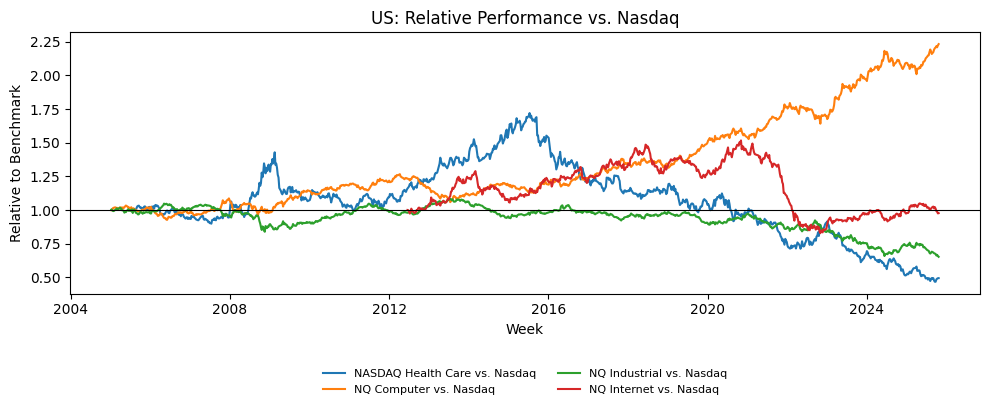

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

min_obs = 520
alpha = 0.10

# 1) Granger-gefilterte Paare
filtered = granger_results[
    (granger_results["n_obs"] >= min_obs) &
    (
        (granger_results["p_CN_to_US"] <= alpha) |
        (granger_results["p_US_to_CN"] <= alpha)
    )
].copy()

us_indices = sorted(filtered["US_Index"].unique().tolist())

benchmark_name = "Nasdaq"

# 2) US-Daten vorbereiten
us_df = friday_df.copy()
us_df["Clsidx"] = pd.to_numeric(us_df["Clsidx"], errors="coerce")
us_df.loc[us_df["Clsidx"] <= 0, "Clsidx"] = np.nan

def yearweek_to_date(s):
    year, week = s.split("-")
    return pd.Timestamp.fromisocalendar(int(year), int(week), 1)

us_df["WeekStart"] = us_df["YearWeek"].astype(str).apply(yearweek_to_date)

# -------------------------------------------------
# WICHTIG: Wir brauchen
#  - alle Granger-Indizes  (us_indices)
#  - UND den Benchmark      (benchmark_name)
# also filtern wir auf: us_indices + [benchmark_name]
# -------------------------------------------------
need_names = set(us_indices) | {benchmark_name}
us_df = us_df[us_df["IndexName"].isin(need_names)].copy()

# Mehrere Zeilen pro Woche/Index -> mitteln
us_df = (
    us_df
    .groupby(["IndexName", "WeekStart"], as_index=False)["Clsidx"]
    .mean()
    .sort_values(["IndexName", "WeekStart"])
)

# Log-Returns
us_df["LogReturn"] = (
    np.log(us_df["Clsidx"])
    .groupby(us_df["IndexName"])
    .diff()
)

# Pivot
us_pivot = us_df.pivot(index="WeekStart", columns="IndexName", values="LogReturn").sort_index()

# prüfen, ob Benchmark jetzt drin ist
if benchmark_name not in us_pivot.columns:
    raise ValueError(f"Benchmark '{benchmark_name}' still not found. Check friday_df['IndexName'].unique().")

# nur Wochen mit Benchmark
us_pivot = us_pivot.dropna(subset=[benchmark_name])

# 3) Plot
plt.figure(figsize=(10, 5))
for name in us_indices:
    if name == benchmark_name or name not in us_pivot:
        continue
    pair = us_pivot[[benchmark_name, name]].dropna()
    if pair.empty:
        continue
    ex_ret = (pair[name] - pair[benchmark_name]).cumsum()
    rel_series = np.exp(ex_ret)
    plt.plot(rel_series.index, rel_series.values, label=f"{name} vs. {benchmark_name}")

plt.axhline(1.0, color="black", linewidth=0.8)
plt.title(f"US: Relative Performance vs. {benchmark_name}", fontsize=12)
plt.ylabel("Relative to Benchmark")
plt.xlabel("Week")

# Legende unten
plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.25),
    ncol=2,
    fontsize=8,
    frameon=False
)
plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.show()


In [13]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests

max_lag = 26  # wie in deinem ursprünglichen Lauf

def compute_log_returns(df, time_col, price_col, id_col, id_value, out_col):
    """Hilfsfunktion: gibt ein DataFrame mit [YearWeek, out_col] zurück."""
    sub = df[df[id_col] == id_value].copy()
    sub = sub.sort_values(time_col)
    sub[price_col] = pd.to_numeric(sub[price_col], errors="coerce")
    sub[out_col] = np.log(sub[price_col]).diff()
    return sub[[time_col, out_col]].dropna()

def all_lag_pvalues(two_col_array: np.ndarray, maxlag: int):
    """
    two_col_array[:,0] = dependent
    two_col_array[:,1] = cause
    returns dict {lag: p_value}
    """
    res = grangercausalitytests(two_col_array, maxlag=maxlag, verbose=False)
    lag_p = {}
    for lag, out in res.items():
        testdict = out[0] if isinstance(out, tuple) else out
        if "ssr_ftest" in testdict:
            lag_p[lag] = testdict["ssr_ftest"][1]
        else:
            lag_p[lag] = np.nan
    return lag_p

rows = []

# wir mergen über YearWeek; US = friday_df, CN = merged_weekly_cn
for _, row in us_driven.iterrows():
    us_name = row["US_Index"]
    cn_name = row["CN_Index"]

    # US weekly returns
    us_ret = compute_log_returns(
        friday_df, "YearWeek", "Clsidx", "IndexName", us_name, "US_Ret"
    )

    # CN weekly returns
    cn_ret = compute_log_returns(
        merged_weekly_cn, "Date", "Closing", "EnglishName", cn_name, "CN_Ret"
    )

    merged = pd.merge(us_ret, cn_ret, left_on="YearWeek", right_on="Date", how="inner").dropna()
    if len(merged) < max_lag + 10:
        continue

    data = merged[["US_Ret", "CN_Ret"]].to_numpy()

    # CN -> US
    cn_us_p = all_lag_pvalues(data, max_lag)
    for lag, pval in cn_us_p.items():
        rows.append({
            "US_Index": us_name,
            "CN_Index": cn_name,
            "direction": "CN→US",
            "lag": lag,
            "p_value": pval,
            "n_obs": len(merged)
        })

    # US -> CN (Spalten tauschen)
    us_cn_p = all_lag_pvalues(data[:, ::-1], max_lag)
    for lag, pval in us_cn_p.items():
        rows.append({
            "US_Index": us_name,
            "CN_Index": cn_name,
            "direction": "US→CN",
            "lag": lag,
            "p_value": pval,
            "n_obs": len(merged)
        })

# optional: dasselbe für cn_driven (falls du sicher gehen willst, dass alle drin sind)
for _, row in cn_driven.iterrows():
    us_name = row["US_Index"]
    cn_name = row["CN_Index"]

    us_ret = compute_log_returns(
        friday_df, "YearWeek", "Clsidx", "IndexName", us_name, "US_Ret"
    )
    cn_ret = compute_log_returns(
        merged_weekly_cn, "Date", "Closing", "EnglishName", cn_name, "CN_Ret"
    )
    merged = pd.merge(us_ret, cn_ret, left_on="YearWeek", right_on="Date", how="inner").dropna()
    if len(merged) < max_lag + 10:
        continue

    data = merged[["US_Ret", "CN_Ret"]].to_numpy()

    # nur ergänzen, falls noch nicht drin – oder du lässt es einfach doppelt

    cn_us_p = all_lag_pvalues(data, max_lag)
    for lag, pval in cn_us_p.items():
        rows.append({
            "US_Index": us_name,
            "CN_Index": cn_name,
            "direction": "CN→US",
            "lag": lag,
            "p_value": pval,
            "n_obs": len(merged)
        })

    us_cn_p = all_lag_pvalues(data[:, ::-1], max_lag)
    for lag, pval in us_cn_p.items():
        rows.append({
            "US_Index": us_name,
            "CN_Index": cn_name,
            "direction": "US→CN",
            "lag": lag,
            "p_value": pval,
            "n_obs": len(merged)
        })

# alles in ein DataFrame
lag_pvalues = pd.DataFrame(rows)

# schön sortieren
lag_pvalues = lag_pvalues.sort_values(
    ["US_Index", "CN_Index", "direction", "lag"]
).reset_index(drop=True)

display(lag_pvalues)


/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/ts

,US_Index,CN_Index,direction,lag,p_value,n_obs
0,NASDAQ Health Care,CSI 800 Pharmaceuticals and Biotechnology Index,CN→US,1,0.057432,631
1,NASDAQ Health Care,CSI 800 Pharmaceuticals and Biotechnology Index,CN→US,2,0.132803,631
2,NASDAQ Health Care,CSI 800 Pharmaceuticals and Biotechnology Index,CN→US,3,0.132979,631
3,NASDAQ Health Care,CSI 800 Pharmaceuticals and Biotechnology Index,CN→US,4,0.245415,631
4,NASDAQ Health Care,CSI 800 Pharmaceuticals and Biotechnology Index,CN→US,5,0.247165,631
...,...,...,...,...,...,...
775,NQ Internet,SZSE Information Technology Sector Index,US→CN,22,0.062933,659
776,NQ Internet,SZSE Information Technology Sector Index,US→CN,23,0.061621,659
777,NQ Internet,SZSE Information Technology Sector Index,US→CN,24,0.078294,659
778,NQ Internet,SZSE Information Technology Sector Index,US→CN,25,0.060722,659


In [14]:
# Parameter
MAX_LAG = 26

def granger_cn_to_us_from_pair(pair_df, maxlag=MAX_LAG):
    """
    Erwartet ein DataFrame aus make_pair_timeseries mit Spalten:
    Date, US_Close, CN_Close, US_Ret, CN_Ret
    und berechnet p-Werte für CN→US.
    """
    df = pair_df[["US_Ret", "CN_Ret"]].dropna()
    arr = df[["US_Ret", "CN_Ret"]].to_numpy()  # US zuerst, CN zweite Spalte -> CN→US
    res = grangercausalitytests(arr, maxlag=maxlag, verbose=False)
    lag_p = {}
    for lag, out in res.items():
        testdict = out[0] if isinstance(out, tuple) else out
        lag_p[lag] = testdict["ssr_ftest"][1]
    return lag_p

rows = []

for us_name, cn_list in us_cn_mapping.items():
    for cn_name in cn_list:
        # 1) Daten für genau dieses Paar bauen
        pair_df = make_pair_timeseries(
            friday_df,
            merged_weekly_cn,
            us_name=us_name,
            cn_name=cn_name
        )
        # falls es für ein Paar keine Daten gibt, überspringen
        if pair_df is None or pair_df.empty:
            continue

        # 2) Granger p-Werte holen
        try:
            lag_p = granger_cn_to_us_from_pair(pair_df, maxlag=MAX_LAG)
        except Exception as e:
            # falls mal was schiefgeht (zu wenige Zeilen o.ä.), trotzdem eine Zeile schreiben
            row = {
                "US_Index": us_name,
                "CN_Index": cn_name,
                "direction": "CN→US",
                "error": str(e)
            }
            rows.append(row)
            continue

        # 3) Zeile bauen
        row = {
            "US_Index": us_name,
            "CN_Index": cn_name,
            "direction": "CN→US",
        }
        for lag in range(1, MAX_LAG + 1):
            row[f"Lag_{lag}"] = lag_p.get(lag, np.nan)
        # kleinsten p-Wert merken
        row["min_p_value"] = min(v for v in lag_p.values() if pd.notna(v))
        rows.append(row)

# 4) DataFrame
granger_df = pd.DataFrame(rows)

# 5) Styling
def highlight_pvals(val):
    if pd.isna(val):
        return ""
    if val < 0.05:
        return "background-color: #a8e6a1"  # grün
    elif val < 0.1:
        return "background-color: #fff3b0"  # gelb


lag_cols = [c for c in granger_df.columns if c.startswith("Lag_")]

styled = (
    granger_df
    .style
    .applymap(highlight_pvals, subset=lag_cols)
    .background_gradient(subset=["min_p_value"], cmap="RdYlGn_r")
    .format("{:.4f}", subset=lag_cols + ["min_p_value"])
)

styled

NameError: name 'make_pair_timeseries' is not defined

In [ ]:
# Parameter
MAX_LAG = 26

def granger_cn_to_us_from_pair(pair_df, maxlag=MAX_LAG):
    """
    Erwartet ein DataFrame aus make_pair_timeseries mit Spalten:
    Date, US_Close, CN_Close, US_Ret, CN_Ret
    und berechnet p-Werte für CN→US.
    """
    df = pair_df[["CN_Ret", "US_Ret"]].dropna()
    arr = df[["CN_Ret", "US_Ret"]].to_numpy()  # US zuerst, CN zweite Spalte -> CN→US
    res = grangercausalitytests(arr, maxlag=maxlag, verbose=False)
    lag_p = {}
    for lag, out in res.items():
        testdict = out[0] if isinstance(out, tuple) else out
        lag_p[lag] = testdict["ssr_ftest"][1]
    return lag_p

rows = []

for us_name, cn_list in us_cn_mapping.items():
    for cn_name in cn_list:
        # 1) Daten für genau dieses Paar bauen
        pair_df = make_pair_timeseries(
            friday_df,
            merged_weekly_cn,
            us_name=us_name,
            cn_name=cn_name
        )
        # falls es für ein Paar keine Daten gibt, überspringen
        if pair_df is None or pair_df.empty:
            continue

        # 2) Granger p-Werte holen
        try:
            lag_p = granger_cn_to_us_from_pair(pair_df, maxlag=MAX_LAG)
        except Exception as e:
            # falls mal was schiefgeht (zu wenige Zeilen o.ä.), trotzdem eine Zeile schreiben
            row = {
                "US_Index": us_name,
                "CN_Index": cn_name,
                "direction": "US->CN",
                "error": str(e)
            }
            rows.append(row)
            continue

        # 3) Zeile bauen
        row = {
            "US_Index": us_name,
            "CN_Index": cn_name,
            "direction": "US->CN",
        }
        for lag in range(1, MAX_LAG + 1):
            row[f"Lag_{lag}"] = lag_p.get(lag, np.nan)
        # kleinsten p-Wert merken
        row["min_p_value"] = min(v for v in lag_p.values() if pd.notna(v))
        rows.append(row)

# 4) DataFrame
granger_df = pd.DataFrame(rows)

# 5) Styling
def highlight_pvals(val):
    if pd.isna(val):
        return ""
    if val < 0.05:
        return "background-color: #a8e6a1"  # grün
    elif val < 0.1:
        return "background-color: #fff3b0"  # gelb


lag_cols = [c for c in granger_df.columns if c.startswith("Lag_")]

styled = (
    granger_df
    .style
    .applymap(highlight_pvals, subset=lag_cols)
    .background_gradient(subset=["min_p_value"], cmap="RdYlGn_r")
    .format("{:.4f}", subset=lag_cols + ["min_p_value"])
)

styled

/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/ts

,US_Index,CN_Index,direction,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8,Lag_9,Lag_10,Lag_11,Lag_12,Lag_13,Lag_14,Lag_15,Lag_16,Lag_17,Lag_18,Lag_19,Lag_20,Lag_21,Lag_22,Lag_23,Lag_24,Lag_25,Lag_26,min_p_value,error
0,NASDAQ Health Care,CSI 800 Pharmaceuticals and Biotechnology Index,US->CN,0.0757,0.2172,0.4017,0.5230,0.4598,0.5483,0.6323,0.7186,0.6467,0.7042,0.3886,0.1938,0.1420,0.1587,0.2208,0.2596,0.2737,0.2991,0.3209,0.3785,0.1225,0.1465,0.1543,0.1511,0.1801,0.2275,0.0757,nan
1,NASDAQ Health Care,CSI Health Care 100 Index,US->CN,0.5775,0.2200,0.3875,0.3855,0.4710,0.5982,0.7171,0.6056,0.6560,0.6389,0.4172,0.0716,0.0877,0.1086,0.1477,0.1515,0.1065,0.1282,0.1447,0.1883,0.1656,0.0959,0.1487,0.1254,0.1354,0.0232,0.0232,nan
2,NASDAQ Health Care,Pharmaceutical & Biological Index,US->CN,0.1291,0.2380,0.2017,0.3169,0.2976,0.1993,0.2938,0.3545,0.4260,0.1834,0.2404,0.2969,0.3252,0.3515,0.3669,0.3511,0.4080,0.4772,0.5959,0.4942,0.5187,0.6004,0.5991,0.6422,0.7151,0.6870,0.1291,nan
3,NASDAQ Health Care,SSE STAR Biology and Medicine Index,US->CN,0.3400,0.6204,0.8129,0.7887,0.8728,0.9254,0.8698,0.9123,0.9353,0.9715,0.8767,0.5903,0.5937,0.6862,0.6810,0.7148,0.6554,0.5825,0.4494,0.3905,0.3411,0.2643,0.2613,0.3351,0.3653,0.3458,0.2613,nan
4,NQ Biotechnology,SSE STAR Biology and Medicine Index,US->CN,0.5289,0.7869,0.8574,0.8000,0.8890,0.9475,0.9204,0.9468,0.9307,0.9755,0.9401,0.7859,0.7217,0.8147,0.8323,0.8764,0.8417,0.8109,0.7512,0.6707,0.6460,0.6043,0.6194,0.6330,0.6721,0.6331,0.5289,nan
5,NQ Biotechnology,CSI WIND Biotechnology Index,US->CN,0.3570,0.6176,0.7146,0.7442,0.5163,0.4642,0.5224,0.5457,0.6078,0.6690,0.6721,0.6411,0.6508,0.7236,0.8022,0.8186,0.6106,0.6180,0.6782,0.7366,0.3924,0.4371,0.4365,0.4920,0.5110,0.5704,0.3570,nan
6,NQ Computer,SSE Information Technology Sector index,US->CN,0.0078,0.0031,0.0036,0.0094,0.0082,0.0106,0.0101,0.0194,0.0092,0.0153,0.0245,0.0337,0.0513,0.0662,0.1012,0.1361,0.0788,0.0440,0.0528,0.0720,0.1066,0.1226,0.0867,0.1055,0.1071,0.0505,0.0031,nan
7,NQ Computer,CSI Information Technology index,US->CN,0.9261,0.0036,0.0105,0.0000,0.0001,0.0003,0.0006,0.0010,0.0020,0.0006,0.0012,0.0004,0.0007,0.0004,0.0008,0.0010,0.0016,0.0006,0.0009,0.0008,0.0014,0.0016,0.0025,0.0016,0.0024,0.0031,0.0000,nan
8,NQ Computer,SZSE Information Technology Sector Index,US->CN,0.0001,0.0000,0.0001,0.0003,0.0003,0.0003,0.0002,0.0001,0.0002,0.0001,0.0001,0.0002,0.0002,0.0004,0.0006,0.0005,0.0002,0.0002,0.0002,0.0005,0.0008,0.0009,0.0009,0.0012,0.0018,0.0004,0.0000,nan
9,NQ Computer,ELECTRONIC EQUIPMENT INDEX,US->CN,0.0000,0.0002,0.0005,0.0016,0.0018,0.0019,0.0040,0.0026,0.0050,0.0051,0.0079,0.0125,0.0153,0.0350,0.0430,0.0294,0.0377,0.0534,0.0534,0.0689,0.0927,0.1351,0.1679,0.1800,0.2624,0.1938,0.0000,nan


In [ ]:
top = granger_df.sort_values("min_p_value").head(3)
top


,US_Index,CN_Index,direction,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,...,Lag_19,Lag_20,Lag_21,Lag_22,Lag_23,Lag_24,Lag_25,Lag_26,min_p_value,error
20,NQ Transportation,Transportation & Storage Index,CN→US,0.455686,0.753675,0.934323,0.917314,0.871298,0.932790,0.900225,...,0.000947,0.001315,0.001847,0.001888,0.002155,0.003061,0.009670,0.013372,0.000417,NaN
1,NASDAQ Health Care,CSI Health Care 100 Index,CN→US,0.755742,0.291020,0.465279,0.579618,0.664918,0.028199,0.042069,...,0.027675,0.034616,0.047973,0.040069,0.054437,0.085146,0.087375,0.106575,0.016573,NaN
10,NQ Computer,Information equipment,CN→US,0.830766,0.923598,0.978364,0.659769,0.788295,0.754388,0.461890,...,0.029365,0.043247,0.056482,0.057459,0.074745,0.028944,0.041756,0.044621,0.028944,NaN


In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import VAR
import numpy as np

# 1. Top-3-Paare aus deiner großen Tabelle
top3 = granger_df.sort_values("min_p_value").head(3)

results = []

for _, row in top3.iterrows():
    us = row["US_Index"]
    cn = row["CN_Index"]

    # 2. Daten für genau dieses Paar holen
    pair_df = make_pair_timeseries(
        friday_df,
        merged_weekly_cn,
        us_name=us,
        cn_name=cn
    )
    pair_df = pair_df.dropna(subset=["US_Ret", "CN_Ret"])

    # falls zu wenig Daten: überspringen
    if len(pair_df) < 30:
        results.append({
            "US_Index": us,
            "CN_Index": cn,
            "N": len(pair_df),
            "GC_CN_to_US_p_min_lag4": np.nan,
            "GC_US_to_CN_p_min_lag4": np.nan,
            "VAR_CN_to_US_p": np.nan,
            "VAR_US_to_CN_p": np.nan,
            "note": "zu wenig Daten"
        })
        continue

    # 3. Granger: CN -> US
    arr_cn_us = pair_df[["US_Ret", "CN_Ret"]].to_numpy()
    gc_cn_us = grangercausalitytests(arr_cn_us, maxlag=4, verbose=False)
    p_cn_us = [gc_cn_us[lag][0]["ssr_ftest"][1] for lag in range(1, 5)]
    p_cn_us_min = min(p_cn_us)

    # 4. Granger: US -> CN
    arr_us_cn = pair_df[["CN_Ret", "US_Ret"]].to_numpy()
    gc_us_cn = grangercausalitytests(arr_us_cn, maxlag=4, verbose=False)
    p_us_cn = [gc_us_cn[lag][0]["ssr_ftest"][1] for lag in range(1, 5)]
    p_us_cn_min = min(p_us_cn)

    # 5. VAR schätzen
    var_mod = VAR(pair_df[["US_Ret", "CN_Ret"]])
    var_res = var_mod.fit(maxlags=26)

    # VAR-Causality: CN -> US
    var_gc_cn_us = var_res.test_causality("US_Ret", ["CN_Ret"], kind="f")
    p_var_cn_us = var_gc_cn_us.pvalue

    # VAR-Causality: US -> CN
    var_gc_us_cn = var_res.test_causality("CN_Ret", ["US_Ret"], kind="f")
    p_var_us_cn = var_gc_us_cn.pvalue

    results.append({
        "US_Index": us,
        "CN_Index": cn,
        "N": len(pair_df),
        "GC_CN_to_US_p_min_lag4": p_cn_us_min,
        "GC_US_to_CN_p_min_lag4": p_us_cn_min,
        "VAR_CN_to_US_p": p_var_cn_us,
        "VAR_US_to_CN_p": p_var_us_cn,
        "note": ""
    })

summary_df = pd.DataFrame(results)
summary_df


/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/ts

,US_Index,CN_Index,N,GC_CN_to_US_p_min_lag4,GC_US_to_CN_p_min_lag4,VAR_CN_to_US_p,VAR_US_to_CN_p,note
0,NQ Industrial,CSI Midstream Manufacturing Industry Index,1502,0.180120,0.000028,0.089675,0.006553,
1,NQ Computer,CSI Information Technology index,1605,0.571896,0.000025,0.927642,0.002924,
2,NQ Transportation,CSI China Mainland Transportation index,1545,0.850797,0.000028,0.872167,0.001456,


In [ ]:
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

def prepare_pair_ts(friday_df, merged_weekly_cn, us_name, cn_name):
    pair_df = make_pair_timeseries(
        friday_df,
        merged_weekly_cn,
        us_name=us_name,
        cn_name=cn_name
    )
    pair_df = pair_df.dropna(subset=["US_Ret", "CN_Ret"]).copy()
    # Reihenfolge festlegen: erst US, dann CN
    return pair_df[["US_Ret", "CN_Ret"]]

def run_var_and_irf(pair_df, maxlags=4, irf_horizon=12):
    model = VAR(pair_df)
    res = model.fit(maxlags)
    irf = res.irf(irf_horizon)

    # Plot: Wirkung eines CN-Schocks auf US
    fig = irf.plot(orth=True)
    plt.suptitle("IRF (orthogonal): Schocks in US_Ret und CN_Ret", y=1.02)
    plt.show()

    return res, irf

# Beispiel für eines deiner drei Paare
us = "NQ Transportation"
cn = "Transportation & Storage Index"

pair_df = prepare_pair_ts(friday_df, merged_weekly_cn, us, cn)
res, irf = run_var_and_irf(pair_df, maxlags=4, irf_horizon=12)


NameError: name 'make_pair_timeseries' is not defined

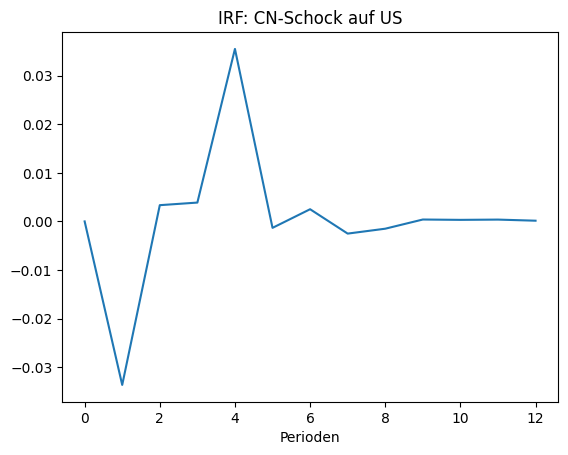

In [ ]:
# Effekt von CN_Ret (2) auf US_Ret (1)
cn_on_us = irf.irfs[:, 0, 1]  # [horizont, ziel=0=US, schock=1=CN]

plt.plot(cn_on_us)
plt.title("IRF: CN-Schock auf US")
plt.xlabel("Perioden")
plt.show()


In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests
import numpy as np
import pandas as pd

def rolling_granger_cn_to_us(pair_df, maxlag=4, window=200):
    """
    pair_df: DataFrame mit Spalten US_Ret, CN_Ret (keine NaNs)
    maxlag: Granger maxlag
    window: Fenstergröße (Anzahl Beobachtungen pro Rolling-Schätzung)
    """
    df = pair_df[["US_Ret", "CN_Ret"]].dropna().reset_index(drop=True)
    n = len(df)
    results = []

    for start in range(0, n - window + 1):
        end = start + window
        sub = df.iloc[start:end]
        arr = sub[["US_Ret", "CN_Ret"]].to_numpy()  # CN -> US
        try:
            gc = grangercausalitytests(arr, maxlag=maxlag, verbose=False)
            # z.B. Minimum über alle Lags im Fenster
            pvals = [gc[lag][0]["ssr_ftest"][1] for lag in range(1, maxlag+1)]
            pmin = min(pvals)
        except Exception as e:
            pmin = np.nan

        results.append({
            "start_idx": start,
            "end_idx": end,
            "pmin": pmin
        })

    return pd.DataFrame(results)

# Beispiel für dein erstes Paar
pair_df = prepare_pair_ts(friday_df, merged_weekly_cn,
                          "NQ Transportation",
                          "Transportation & Storage Index")

roll_df = rolling_granger_cn_to_us(pair_df, maxlag=4, window=200)

# Plotten
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(roll_df["end_idx"], roll_df["pmin"])
plt.axhline(0.05, color="red", linestyle="--")
plt.title("Rolling Granger CN→US (window=200)")
plt.xlabel("Ende des Fensters (Index)")
plt.ylabel("p-Wert (min über Lags)")
plt.show()


NameError: name 'make_pair_timeseries' is not defined

In [ ]:
top_pairs = [
    ("NQ Transportation", "Transportation & Storage Index"),
    ("NASDAQ Health Care", "CSI Health Care 100 Index"),
    ("NQ Computer", "Information equipment"),
]

for us, cn in top_pairs:
    print(f"\n=== {us}  <--->  {cn} ===")
    pair_df = prepare_pair_ts(friday_df, merged_weekly_cn, us, cn)

    # VAR + IRF
    res, irf = run_var_and_irf(pair_df, maxlags=4, irf_horizon=12)

    # Rolling Granger
    roll_df = rolling_granger_cn_to_us(pair_df, maxlag=4, window=200)
    plt.figure(figsize=(10,4))
    plt.plot(roll_df["end_idx"], roll_df["pmin"])
    plt.axhline(0.05, color="red", linestyle="--")
    plt.title(f"Rolling Granger CN→US: {us} <- {cn}")
    plt.show()



=== NQ Transportation  <--->  Transportation & Storage Index ===


NameError: name 'make_pair_timeseries' is not defined

In [ ]:
import pandas as pd
import numpy as np

def yearweek_to_monday(yearweek: str) -> pd.Timestamp:
    year, week = yearweek.split("-")
    return pd.Timestamp.fromisocalendar(int(year), int(week), 1)  # Montag der ISO-Woche

def make_pair_timeseries(
    friday_df: pd.DataFrame,
    merged_weekly_cn: pd.DataFrame,
    us_name: str,
    cn_name: str,
):
    """
    Nimmt einen US-Indexnamen (wie in friday_df['IndexName'])
    und einen China-Indexnamen (wie in merged_weekly_cn['EnglishName'])
    und gibt ein DataFrame zurück:
        Date | US_Close | CN_Close | US_Ret | CN_Ret
    wöchentlich, nur gemeinsame Wochen.
    """
    # --- US-Teil ---
    us_sub = friday_df[friday_df["IndexName"] == us_name].copy()
    if us_sub.empty:
        raise ValueError(f"US index '{us_name}' not found in friday_df.")
    us_sub = us_sub[["YearWeek", "Clsidx"]].copy()
    us_sub["Date"] = us_sub["YearWeek"].astype(str).apply(yearweek_to_monday)
    us_sub = us_sub.sort_values("Date")
    us_sub["US_Close"] = pd.to_numeric(us_sub["Clsidx"], errors="coerce")
    us_sub = us_sub.dropna(subset=["US_Close"])

    # --- CN-Teil ---
    cn_sub = merged_weekly_cn[merged_weekly_cn["EnglishName"] == cn_name].copy()
    if cn_sub.empty:
        raise ValueError(f"CN index '{cn_name}' not found in merged_weekly_cn.")
    # dort heißt die Kalenderwoche bereits 'YearWeek'
    if "YearWeek" not in cn_sub.columns:
        cn_sub["YearWeek"] = cn_sub["Date"].astype(str)

    cn_sub = cn_sub[["YearWeek", "Closing"]].copy()
    cn_sub["Date"] = cn_sub["YearWeek"].astype(str).apply(yearweek_to_monday)
    cn_sub = cn_sub.sort_values("Date")
    cn_sub["CN_Close"] = pd.to_numeric(cn_sub["Closing"], errors="coerce")
    cn_sub = cn_sub.dropna(subset=["CN_Close"])

    # --- mergen auf gemeinsame Wochen ---
    data = pd.merge(us_sub[["Date", "US_Close"]],
                    cn_sub[["Date", "CN_Close"]],
                    on="Date",
                    how="inner").sort_values("Date")

    # Log-Returns
    data["US_Ret"] = np.log(data["US_Close"]).diff()
    data["CN_Ret"] = np.log(data["CN_Close"]).diff()
    data = data.dropna(subset=["US_Ret", "CN_Ret"]).reset_index(drop=True)
    return data


In [ ]:
test_pair = make_pair_timeseries(friday_df, merged_weekly_cn,
                                 us_name="NASDAQ Health Care",
                                 cn_name="CSI 800 Pharmaceuticals and Biotechnology Index")
print(test_pair.head())


        Date  US_Close  CN_Close    US_Ret    CN_Ret
0 2012-12-24    343.62  5055.206 -0.021649  0.048626
1 2012-12-31    359.84  4984.736  0.046123 -0.014038
2 2013-01-07    367.56  5185.010  0.021227  0.039391
3 2013-01-14    366.94  5594.160 -0.001688  0.075951
4 2013-01-21    372.50  5613.496  0.015039  0.003451


In [ ]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests

def run_var_and_granger(data: pd.DataFrame, maxlags: int = 26, verbose: bool = True):
    """
    data: kommt aus make_pair_timeseries → hat Spalten Date, US_Ret, CN_Ret
    """
    var_data = data[["US_Ret", "CN_Ret"]].copy()
    var_data.index = data["Date"]

    model = VAR(var_data)
    res = model.fit(maxlags)
    if verbose:
        print(res.summary())

    print("\nGranger: CN → US (null: CN verursacht US NICHT)")
    grangercausalitytests(var_data[["US_Ret", "CN_Ret"]], maxlag=maxlags, verbose=verbose)

    print("\nGranger: US → CN (null: US verursacht CN NICHT)")
    grangercausalitytests(var_data[["CN_Ret", "US_Ret"]], maxlag=maxlags, verbose=verbose)

    return res


NameError: name 'pair_data' is not defined

In [ ]:
pair_data = make_pair_timeseries(friday_df, merged_weekly_cn,
                                 "NASDAQ Health Care",
                                 "CSI 800 Pharmaceuticals and Biotechnology Index")
var_res = run_var_and_granger(pair_data, maxlags=26)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 06, Nov, 2025
Time:                     10:43:10
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -12.7748
Nobs:                     605.000    HQIC:                  -13.2463
Log likelihood:           2486.94    FPE:                1.30970e-06
AIC:                     -13.5466    Det(Omega_mle):     1.10721e-06
--------------------------------------------------------------------
Results for equation US_Ret
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              0.001747         0.001328            1.316           0.188
L1.US_Ret         -0.070023         0.044183           -1.585           0.113
L1.CN_Ret          0.073931         0.039435            1.875          

/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


In [ ]:
pair_data.head()

,Date,US_Close,CN_Close,US_Ret,CN_Ret
0,2012-12-24,343.62,5055.206,-0.021649,0.048626
1,2012-12-31,359.84,4984.736,0.046123,-0.014038
2,2013-01-07,367.56,5185.010,0.021227,0.039391
3,2013-01-14,366.94,5594.160,-0.001688,0.075951
4,2013-01-21,372.50,5613.496,0.015039,0.003451


In [ ]:
import numpy as np
import pandas as pd

def dy_spillover_from_var(res, h: int = 10):
    """
    res: VARResults aus statsmodels (2 Variablen: US_Ret, CN_Ret)
    h: Horizont
    returns: (total_spill, spill_df)
    """
    Psi = res.ma_rep(maxn=h-1)
    Psi = np.asarray(Psi)  # (h, k, k)
    Sigma = np.asarray(res.sigma_u)
    k = Psi.shape[1]

    sigma_diag = np.diag(Sigma).astype(float)

    num = np.zeros((k, k), dtype=float)
    den = np.zeros(k, dtype=float)

    for s in range(h):
        Ps = Psi[s]           # (k, k)
        B  = Ps @ Sigma       # (k, k)
        num += (B * B) / sigma_diag[np.newaxis, :]
        den += np.sum(B * Ps, axis=1)

    GFEVD = num / den.reshape(-1, 1)

    # Zeilen normalisieren
    row_sums = GFEVD.sum(axis=1, keepdims=True)
    GFEVD = GFEVD / row_sums

    off_diag = GFEVD.sum() - np.trace(GFEVD)
    total_spill = off_diag / k

    labels = ["US", "CN"][:k]
    spill_df = pd.DataFrame(
        GFEVD,
        index=[f"{l}_recipient" for l in labels],
        columns=[f"{l}_source" for l in labels]
    )
    return total_spill, spill_df


In [ ]:
total_spill, spill_df = dy_spillover_from_var(var_res, h=10)
print(f"Total spillover index: {total_spill:.4f}")
print(spill_df)


Total spillover index: 0.0754
              US_source  CN_source
US_recipient   0.925964   0.074036
CN_recipient   0.076714   0.923286


In [ ]:
from arch import arch_model
import matplotlib.pyplot as plt

def volatility_spillover_garch(pair_data: pd.DataFrame, window: int = 52):
    # GARCH arbeitet meist besser mit skalierten Returns
    us_garch = arch_model(pair_data["US_Ret"] * 100, p=1, q=1).fit(disp='off')
    cn_garch = arch_model(pair_data["CN_Ret"] * 100, p=1, q=1).fit(disp='off')

    us_std = us_garch.resid / us_garch.conditional_volatility
    cn_std = cn_garch.resid / cn_garch.conditional_volatility

    roll_corr = us_std.rolling(window=window, min_periods=20).corr(cn_std)

    plt.figure(figsize=(10, 4))
    plt.plot(pair_data["Date"], roll_corr)
    plt.title(f"Rolling corr. of standardized residuals (window={window})")
    plt.show()

    return roll_corr


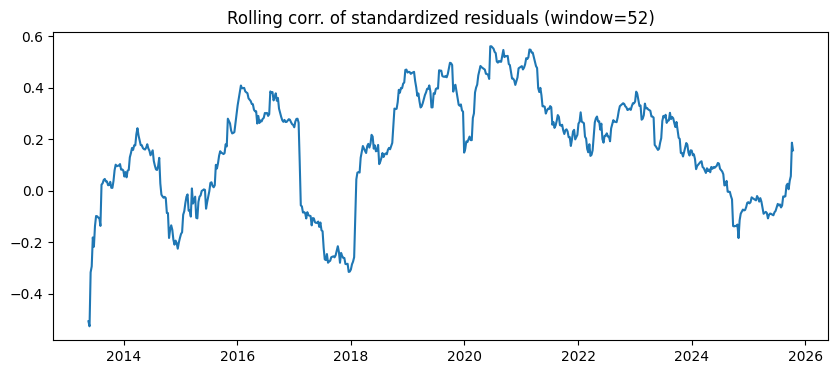

Durchschnittliche roll. Korrelation: 0.1641298860883948


In [ ]:
roll_corr = volatility_spillover_garch(pair_data, window=52)
print("Durchschnittliche roll. Korrelation:", roll_corr.mean())


In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

def make_lags_from_pair(pair_data: pd.DataFrame, lags: int = 4):
    df = pair_data.copy()
    # Ziel: z.B. US_Ret durch CN-Lags vorhersagen
    for i in range(1, lags + 1):
        df[f"CN_lag{i}"] = df["CN_Ret"].shift(i)
        df[f"US_lag{i}"] = df["US_Ret"].shift(i)
    df = df.dropna().reset_index(drop=True)
    return df

def ml_predict_us_from_cn(pair_data: pd.DataFrame, lags: int = 4):
    df = make_lags_from_pair(pair_data, lags=lags)
    # Features: CN-Lags + optional US-Lags
    feature_cols = [f"CN_lag{i}" for i in range(1, lags+1)] + \
                   [f"US_lag{i}" for i in range(1, lags+1)]
    X = df[feature_cols].values
    y = df["US_Ret"].values

    tscv = TimeSeriesSplit(n_splits=5)
    preds = np.zeros_like(y)
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = xgb.XGBRegressor(
            objective="reg:squarederror",
            n_estimators=120,
            max_depth=3,
            random_state=42,
        )
        model.fit(X_train, y_train)
        preds[test_idx] = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y, preds))
    r2 = r2_score(y, preds)
    print(f"XGBoost (US_Ret ~ CN/US lags) RMSE={rmse:.5f}  R2={r2:.4f}")
    return df, preds


In [ ]:
ml_df, ml_preds = ml_predict_us_from_cn(pair_data, lags=4)


XGBoost (US_Ret ~ CN/US lags) RMSE=0.03432  R2=-0.2418


In [ ]:
results = []

for us_name, cn_list in us_cn_mapping.items():
    for cn_name in cn_list:
        try:
            pair_data = make_pair_timeseries(friday_df, merged_weekly_cn, us_name, cn_name)
            if len(pair_data) < 60:  # etwas Mindestlänge
                print(f"Zu kurz: {us_name} – {cn_name} ({len(pair_data)})")
                continue

            # VAR + Granger
            var_res = VAR(pair_data[["US_Ret", "CN_Ret"]].set_index(pair_data["Date"])).fit(4)
            # einfacher Granger-Wrapper:
            g_cn_us = grangercausalitytests(pair_data[["US_Ret", "CN_Ret"]], maxlag=4, verbose=False)
            g_us_cn = grangercausalitytests(pair_data[["CN_Ret", "US_Ret"]], maxlag=4, verbose=False)

            # minimalen p-Wert rausziehen
            p_cn_us = min([g_cn_us[lag][0]["ssr_ftest"][1] for lag in g_cn_us])
            p_us_cn = min([g_us_cn[lag][0]["ssr_ftest"][1] for lag in g_us_cn])

            # FEVD
            total_spill, spill_df = dy_spillover_from_var(var_res, h=10)
            cn_to_us_share = spill_df.loc["US_recipient", "CN_source"]
            us_to_cn_share = spill_df.loc["CN_recipient", "US_source"]

            results.append({
                "US_Index": us_name,
                "CN_Index": cn_name,
                "n_obs": len(pair_data),
                "p_CN_to_US": p_cn_us,
                "p_US_to_CN": p_us_cn,
                "FEVD_CN_to_US": cn_to_us_share,
                "FEVD_US_to_CN": us_to_cn_share,
                "FEVD_total": total_spill,
            })

        except Exception as e:
            print(f"Fehler bei {us_name} – {cn_name}: {e}")

spillover_results = pd.DataFrame(results).sort_values(
    ["p_CN_to_US", "p_US_to_CN", "FEVD_CN_to_US"]
)
display(spillover_results)


/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: Futur

Zu kurz: NQ Internet – ELECTRONIC EQUIPMENT INDEX (35)


/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: Futur

,US_Index,CN_Index,n_obs,p_CN_to_US,p_US_to_CN,FEVD_CN_to_US,FEVD_US_to_CN,FEVD_total
15,NQ Industrial,SSE Upstream Industry Index,711,0.060410,0.014972,0.056152,0.061079,0.058615
0,NASDAQ Health Care,CSI 800 Pharmaceuticals and Biotechnology Index,631,0.070718,0.075728,0.065156,0.063155,0.064156
5,NQ Biotechnology,CSI WIND Biotechnology Index,514,0.176380,0.356975,0.050244,0.052938,0.051591
18,NQ Industrial,CSI Midstream Manufacturing Industry Index,1502,0.180120,0.000028,0.004529,0.004008,0.004268
17,NQ Industrial,SSE Downstream Industry Index,711,0.235066,0.008444,0.066966,0.070855,0.068911
14,NQ Internet,Information equipment,185,0.245088,0.015401,0.009719,0.061681,0.035700
6,NQ Computer,SSE Information Technology Sector index,825,0.257379,0.003075,0.062850,0.076836,0.069843
12,NQ Internet,CSI Information Technology index,1319,0.276927,0.000317,0.077844,0.095002,0.086423
13,NQ Internet,SZSE Information Technology Sector Index,659,0.282728,0.003350,0.082906,0.100956,0.091931
11,NQ Internet,SSE Information Technology Sector index,659,0.285395,0.028890,0.067820,0.083311,0.075566
